In [1]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial

from gym_duckietown.simulator import Simulator
from casadi import *

import utils
from utils import get_position, my_odometry


DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.2.38 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:nodes:version 6.2.13 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages pyparsing 3.0.7
DEBUG:gym-duckietown:gym-duckietown version 6.1.30 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'advanced_font_features': False, 'headless': False, 'headless_device': 0, 'win32_disable_shaping': False}


In [2]:
plt.rcParams['figure.figsize'] = [7, 7]

In [3]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [4]:
frame_rate = 10
n_samples = 150

env = Simulator("ETH_large_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[3,1],
    seed=42,
    max_steps=float("inf"),
    robot_speed=1.0,
    frame_rate=frame_rate,
)

start_from_trajectory = True

# Trick to let the trajectory extractor see the whole line
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], pi/2]

INFO:duckietown_world: data: /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages/duckietown_world/data


In [5]:
dt = 1.0 / env.frame_rate

In [6]:
env.reset()
traj = utils.get_trajectory(env, samples=n_samples, method="distance", last_value_distance=1.035)
inside, outside = utils.get_border(traj, distance=0.17)
traj = np.vstack([traj[-1], traj])
inside = np.vstack([inside[-1], inside])
outside = np.vstack([outside[-1], outside])

/home/giulio/prog/duckrace/utils.py:390: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


In [7]:
idx = 0
while idx < len(inside):
    # If two consecutive points are too close, remove the second one
    if spatial.distance.euclidean(inside[idx-1], inside[idx]) < 0.05:
        inside[idx] = inside[idx-1]
    elif spatial.distance.euclidean(outside[idx-1], outside[idx]) < 0.05:
        outside[idx] = outside[idx-1]
    idx += 1

In [8]:
if start_from_trajectory:
    env.reset()
    env.unwrapped.start_pose = [[0.3, 0, 0.41029359288296474], pi/2]
    # Why double? Good question
    env.reset()
    env.unwrapped.start_pose = [[0.3, 0, 0.41029359288296474], pi/2]

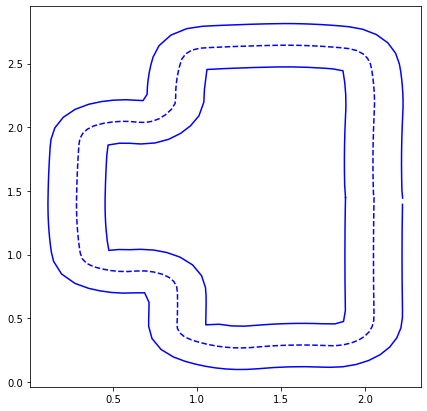

In [9]:
plt.plot(*traj.T, "b--")
plt.plot(*inside.T, "b-")
plt.plot(*outside.T, "b-")

Points wrt alpha:

In [10]:
trajx = MX.sym('trajx')
insx = MX.sym('inside_x')
outx = MX.sym('outside_x')
a = MX.sym('alpha')

x = trajx + a*(outx - insx)/2

F = Function('F',[trajx, insx, outx,  a],[x],['trajx', 'insx', 'outx', 'alpha'],['x'])

In [11]:
N = len(inside)
inside.shape

(150, 2)

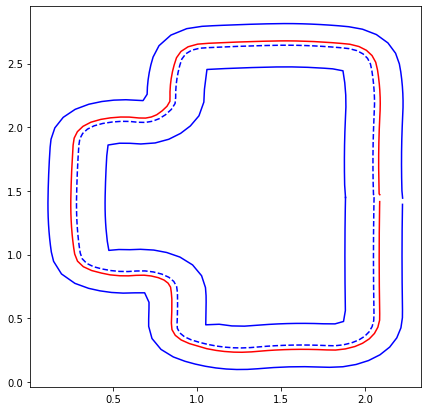

In [12]:
# Test
a = np.ones(N)*0.2
x = F(traj[:-1,0], inside[:,0], outside[:,0], a)
y = F(traj[:-1,1], inside[:,1], outside[:,1], a)

test = np.hstack([x,y])
plt.plot(*traj.T, "b--")
plt.plot(*inside.T, "b-")
plt.plot(*outside.T, "b-")
plt.plot(*test.T, "r-")

### Optimization

In [13]:
opti = Opti()

a = opti.variable(N)
x = opti.variable(N)
y = opti.variable(N)

trajx = opti.parameter(N)
trajy = opti.parameter(N)
insx = opti.parameter(N)
insy = opti.parameter(N)
outx = opti.parameter(N)
outy = opti.parameter(N)
Kl = opti.parameter(1)
Kp = opti.parameter(1)

ds2 = (x[2:]-x[1:-1])**2 + (y[2:]-y[1:-1])**2
obj = Kl*sum1( ds2 ) + Kp*sum1( (atan2(y[2:]-y[1:-1], x[2:]-x[1:-1]) - atan2(y[1:-1]-y[:-2], x[1:-1]-x[:-2]))/(ds2**0.5) )

opti.minimize(obj)

# Constraints Definition
opti.subject_to(x == F(trajx, insx, outx, a))
opti.subject_to(y == F(trajy, insy, outy, a))

opti.subject_to(a <= 1)
opti.subject_to(a >= -1)

# opti.set_initial(a, np.ones(N)*0.5)
opti.set_initial(x, traj[:N,0])
opti.set_initial(y, traj[:N,1])

opti.set_value(trajx, traj[:-1,0])
opti.set_value(trajy, traj[:-1,1])
opti.set_value(insx, inside[:,0])
opti.set_value(insy, inside[:,1])
opti.set_value(outx, outside[:,0])
opti.set_value(outy, outside[:,1])
opti.set_value(Kl, 0.5)
opti.set_value(Kp, 0.5)

# Ipopt
opts = dict()
opts["ipopt.print_level"] = 0
opts["print_time"] = False
opts["verbose"] = False
opti.solver('ipopt',opts)

M = opti.to_function('M',[Kl, Kp],[x, y],['Kl', 'Kp'],['x', 'y'])

In [14]:
# If the track is too wide the interal line can get messy.
# For this reason min(alpha) < 0 and the track need to be recalculated
# inside, outside = utils.get_border(traj, distance=0.17)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



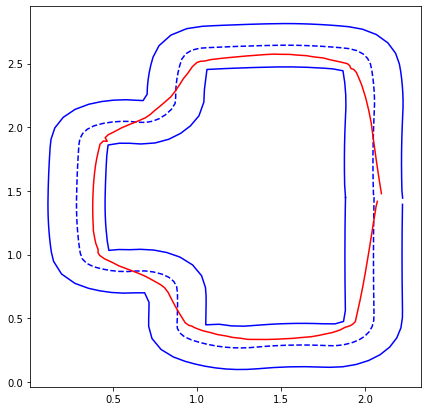

In [15]:
Kl = 1
Kp = 5e-6

xr, yr = M(Kl, Kp)
xr = xr[1:]
yr = yr[1:]

res = np.hstack([xr,yr])
plt.plot(*traj.T, "b--")
plt.plot(*inside.T, "b-")
plt.plot(*outside.T, "b-")
plt.plot(*res.T, "r-")

In [16]:
ref = res
angles = np.zeros(ref.shape[0])
angles[:-1] = np.arctan2(ref[1:,1]-ref[:-1,1], ref[1:,0]-ref[:-1,0])
angles[-1] = np.arctan2(ref[0,1]-ref[-1,1], ref[0,0]-ref[-1,0])
ref = np.concatenate((ref, angles.reshape(-1,1)), axis=1)[::2]

In [17]:
# First loop
Mpc = Function.load('controllers/M_original.casadi')

N_MPC = 5

pose = get_position(env)
distance,index = spatial.KDTree(ref[:,:2]).query([pose.x, pose.y])
delay = round(0.15/dt)
u_delay0 = DM(np.zeros((2, delay)))
r0 = ref[index:index+N_MPC+1, :2].T
t0 = ref[index:index+N_MPC+1, 2].T

# MPC loop
F = utils.model_F(dt=dt)
X_log = np.empty((5,0))
U_log = np.empty((2,0))

x = [pose.x, pose.y, pose.theta, 0, 0]
starting_y = pose.y
r = r0
tr = t0
idx = index
u_delay = u_delay0

kdtree = spatial.KDTree(ref[:, :2])

t = 0
while True:
    u = Mpc(x, r, tr, u_delay,  1e3, 1e2, 1, 0)

    U_log = np.column_stack((U_log, u))
    X_log = np.column_stack((X_log, x))

    u_delay = np.column_stack((u_delay, u))[:, -delay:]

    # simulate
    x = F(x,u)

    distance = (ref[idx, 0] - x[0])**2 + (ref[idx, 1] - x[1])**2

    _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
    if idx+N_MPC+1 < ref.shape[0]:
        r = ref[idx:idx+N_MPC+1, :2].T
        tr = ref[idx:idx+N_MPC+1, 2].T
    else:
        r = vertcat(ref[idx:, :2], ref[:idx+N_MPC+1-ref.shape[0], :2]).T
        tr = vertcat(ref[idx:, 2], ref[:idx+N_MPC+1-ref.shape[0], 2]).T

    if ref[idx, 1] >= starting_y and t >= 10*env.frame_rate:
        break
    t += 1

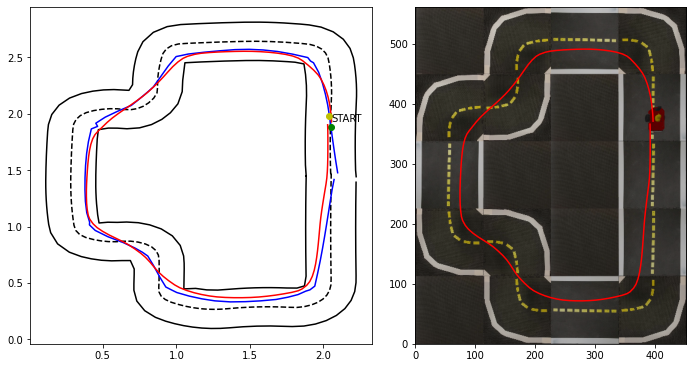

In [18]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AC""")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')
ax_dict["A"].plot(*traj.T, "k--")
ax_dict["A"].plot(*inside.T, "k-")
ax_dict["A"].plot(*outside.T, "k-")
ax_dict["A"].plot(ref[:,0], ref[:,1], "b")
ax_dict["A"].plot(ref[index,0], ref[index,1], 'go')
ax_dict["A"].plot(X_log[0,:], X_log[1,:], "r")
ax_dict["A"].plot(ref[idx, 0], ref[idx,1], 'yo')
utils.show_on_map_array(env, np.array([X_log[0,:], X_log[1,:]]).T, fig=ax_dict["C"])

In [19]:
f"Time per lap: {X_log.shape[1]*dt}s"

'Time per lap: 12.0s'

Text(0.5, 1.0, 'Speed profile')

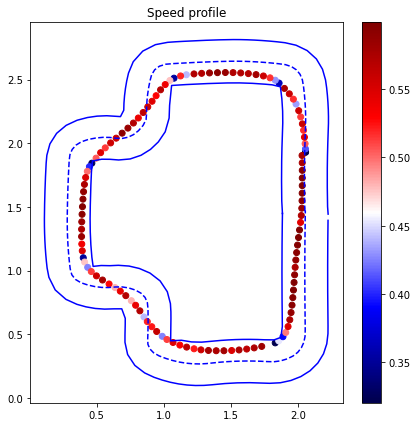

In [22]:
plt.plot(traj[:,0], traj[:,1], "b--")
plt.plot(*inside.T, "b")
plt.plot(*outside.T, "b")
cm = plt.cm.get_cmap('seismic')
sc = plt.scatter(X_log[0,:], X_log[1,:], c=X_log[3,:], cmap=cm, label="Last iteration", vmin=0.32)
plt.colorbar(sc)
plt.title("Speed profile")